In [1]:
import torch
from model import Model, restore
from dataset import ModisDataset, download_url
import matplotlib.pyplot as plt
import numpy as np

tumblack = "#000000"
tumblue = "#0065bd"
tumorange = "#e37222"
tumbluelight = "#64a0c8"
tumgray = "#999999"
tumlightgray = "#dad7cb"

In [46]:
device = torch.device("cpu")

model = Model(input_size=1, hidden_size=256, output_size=1, device=device)
#download_url("https://syncandshare.lrz.de/dl/fiDSPeiaaQtP18a7maBN8okj/model_epoch_8.pth", "/tmp/model.pth")
model.load_state_dict(torch.load("/tmp/model_epoch_29.pth")["model"])
model.train()
dataset = ModisDataset(region="germany",fold="validate")

def variance(y_hat, var_hat):
    """eq 9 in Kendall & Gal"""
    T = y_hat.shape[0]
    sum_squares = (1/T) * (y_hat**2).sum(0)
    squared_sum = ((1/T) * y_hat.sum(0))**2
    epi_var = sum_squares - squared_sum
    ale_var = (1/T) * (var_hat**2).sum(0)
    return epi_var + ale_var, epi_var, ale_var

def epistemic_variance(y_hat):
    """eq 4 in Kendall & Gal"""
    return (y_hat**2).mean(0) - y_hat.mean(0)**2

local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz


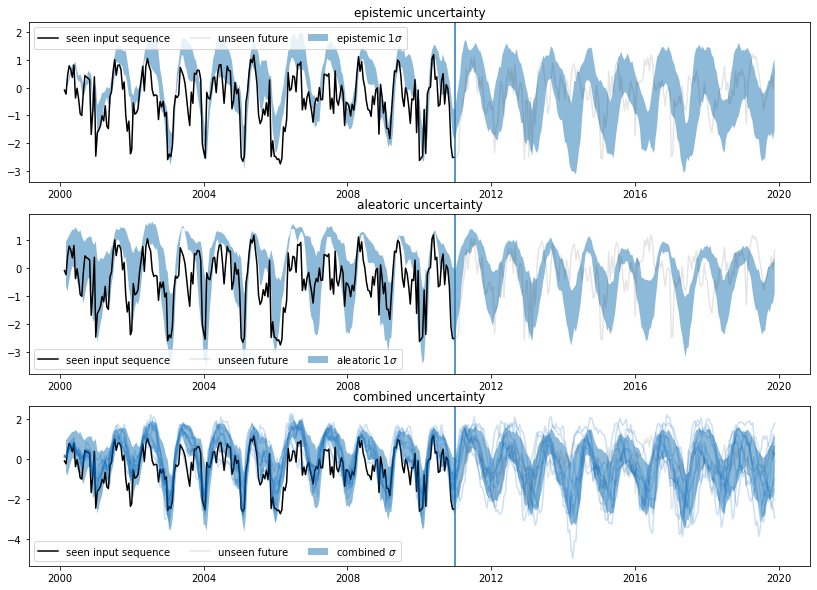

In [49]:
idx = 20

x = dataset.data[idx].astype(float)
date = dataset.date[idx].astype(np.datetime64)

N_seen_points = 250
N_predictions = 10
future = x.shape[0] - N_seen_points

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, axs = plt.subplots(3,1,figsize=(14, 10))
axs = np.array(axs).reshape(-1)

axs[0].set_title("epistemic uncertainty")
axs[1].set_title("aleatoric uncertainty")
axs[2].set_title("combined uncertainty")


y_hat = list()
var_hat = list()
for idx in range(N_predictions):
    model.train()
    x_data = torch.Tensor(x)[None, :N_seen_points].to(device)
    y_pred, log_variance = model(x_data, future=future)
    
    y_hat.append(y_pred[0,:,0].cpu().detach().numpy())
    var_hat.append(log_variance[0,:,0].cpu().detach().numpy())

var_hat = np.vstack(var_hat)
y_hat = np.vstack(y_hat)


var, epi_var, ale_var = variance(y_hat, var_hat)
#epi_var = epistemic_variance(y_hat)
#var = ale_var + epi_var

#sum_squares_var = (1/T) * (var_hat**2).sum(0)

mean = y_hat.mean(0)[:-1]

n_sigma=1
axs[0].fill_between(date[1:], mean+n_sigma*np.sqrt(epi_var[:-1]), mean-n_sigma*np.sqrt(epi_var[:-1]), alpha=.5, label=f"epistemic {n_sigma}"+r"$\sigma$")
axs[1].fill_between(date[1:], mean+n_sigma*np.sqrt(ale_var[:-1]), mean-n_sigma*np.sqrt(ale_var[:-1]), alpha=.5, label=f"aleatoric {n_sigma}"+r"$\sigma$")
axs[2].fill_between(date[1:], mean+n_sigma*np.sqrt(var)[:-1], mean-n_sigma*np.sqrt(var)[:-1], alpha=.5, label=r"combined $\sigma$")
    
for ax in axs:
    ax.plot(date[:N_seen_points], x[:N_seen_points,0], c="#000000", alpha=1, label="seen input sequence")
    ax.plot(date[N_seen_points:], x[N_seen_points:,0], c="#000000", alpha=.1, label="unseen future")
    ax.axvline(x=date[N_seen_points], ymin=0, ymax=1)
    #ax.plot(date[1:], mean,'r')


for y_pred in y_hat:
#y_pred = np.append([np.nan], y_pred[0, :-1, 0].cpu().detach().numpy())
    label = "prediction" if idx == 0 else None
    ax.plot(date[:N_seen_points + future], y_pred, c="#0065bd", label=label, alpha=(1 / N_predictions) ** 0.7)



[ax.legend( ncol=3) for ax in axs]
#ax.set_ylim(0,1)


In [50]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

In [40]:
sum_squares = (1/T) * (y_hat**2).sum(0)
squared_sum = ((1/T) * y_hat.sum(0))**2
sum_squares_var = (1/T) * (var_hat**2).sum(0)

NameError: name 'T' is not defined

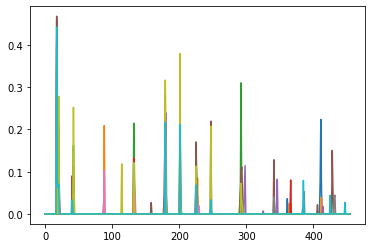

In [33]:
plt.plot(var_hat.T)

In [221]:
sum_squares

array([0.32631078, 0.34460607, 0.40063697, 0.44688568, 0.46605116,
       0.4601743 , 0.47491264, 0.41194358, 0.40345764, 0.38431752,
       0.34843558, 0.31168452, 0.35605842, 0.3836626 , 0.37810585,
       0.3684953 , 0.36615697, 0.14503315, 0.17886053, 0.27615052,
       0.04961591, 0.07757293, 0.10372428, 0.14309686, 0.21548517,
       0.26117396, 0.33800662, 0.3539153 , 0.38020644, 0.47748017,
       0.5025389 , 0.51981443, 0.53711814, 0.51887435, 0.52017754,
       0.4944133 , 0.50563544, 0.4643894 , 0.4582672 , 0.4078593 ,
       0.29561976, 0.32238173, 0.08687126, 0.05387631, 0.22359936,
       0.22875316, 0.25251707, 0.29674295, 0.38364998, 0.44977066,
       0.5161482 , 0.5082508 , 0.5314379 , 0.5429387 , 0.5180383 ,
       0.5089143 , 0.48894858, 0.4589007 , 0.4545711 , 0.4420746 ,
       0.3609649 , 0.36844647, 0.32918006, 0.30080864, 0.25052318,
       0.23905669, 0.04567754, 0.02334515, 0.01985631, 0.06318908,
       0.21981907, 0.32980427, 0.41091105, 0.47018942, 0.51048

In [42]:
T = N_predictions
var_hat = np.vstack(var_hat)
y_hat = np.vstack(y_hat)

In [23]:
(1/T) * (var_hat**2).sum(0)

NameError: name 'T' is not defined

In [63]:
y_hat.sum(y_hat.sum(1)).shape

(10,)